<a href="https://colab.research.google.com/github/eikeschuett/IcebergShipDetection/blob/main/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Object Detection from Sentinel 1 Preprocessed scene

This code runs an object detection over a preprocessed subset of a Sentinel-1 scene (i.e. GRDH IW, orbit file, calibration, terrain correction, convert to dB) and extracts 75x75 pixel subsets around each indiviual object to feed these into our ship-iceberg-classification model.

The testscene i have used is S1B_IW_GRDH_1SDH_20200730T100802_20200730T100827_022699_02B151_F93E. It shows a part of the Illuissat fjord in Greenland. I suspect that virtually all floating objects are icebergs, but it is a nice scene because the density of floating objects is quite high. The processed version is uploaded into the drive.

Unfortunatly, i did not managed to import netCDF-files in colab, most probably due to RAM limitations. Instead, i exported both Sigma0-bands and the LAT and LON-Bands after the preprocessing as individual .tif-files (not as GeoTIFFs, because Colab does not seem to like GeoTIFFs either), zipped the 4 .tifs and uploaded them into my Drive.

Import all required libraries

In [1]:
import numpy as np
import os
from PIL import Image
import skimage.measure as measure
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import pandas as pd

import tensorflow as tf
from google.colab import drive

import zipfile

Create a function for the Lee filter, which will later be used to reduce spackle noise. From here: https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python


In [2]:
def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

Mount my drive to get the preprocessed satellite data and model.

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now that we have access to the drive, import our model.

In [4]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Iceberg_Ship_Classification/model_inc_angle.hd5')

Create temporary working directory and unzip the satellite data to this directory.

In [5]:
# Path to .zip file in my mounted drive
path = "/content/drive/MyDrive/Iceberg_Ship_Classification/Testscenes/"
# Disko bay with icebergs
file = "S1A_IW_GRDH_1SDH_20210115T100027_20210115T100052_036147_043CF4_049C_output.zip" 
#Svalbard scene with ship in the center
#file = "S1B_IW_GRDH_1SDH_20210108T154500_20210108T154525_025065_02FBC6_38D2_output.zip"

# Create temporary working diretory in colab
wdir = "/content/" + file[:-4]
if not os.path.exists(wdir):
    os.makedirs(wdir)
os.chdir(wdir)

with zipfile.ZipFile(path+file, 'r') as zip_ref:
    zip_ref.extractall() # Unzip in working directory

Import the HH and HV bands as numpy arrays. To keep it simple, I will only use a 1000x1000 pixel subset of this scene. From the HH and HV bands we can calculate the total backscatter in a third band.


In [6]:
# The preprocessed data is already 1000 x 1000, so no need to import only a subset

hh = np.array(Image.open(file[:-11] + '_cal_ter_db_UTM_msk_Sigma0_HH_db.tif'))
hv = np.array(Image.open(file[:-11] + '_cal_ter_db_UTM_msk_Sigma0_HV_db.tif'))
inc_angle = np.array(Image.open(file[:-11] + '_cal_ter_db_UTM_msk_IncidenceAngle.tif'))

b3 = hh + hv

# Rescale images between 0 and 1 for faster convergence rate
hh = (hh - hh.min())/(hh.max()-hh.min())
hv = (hv - hv.min())/(hv.max()-hv.min())
b3 = (b3 - b3.min())/(b3.max()-b3.min())

# Also import the arrays containing the latitude and longtitude data.
lat = np.array(Image.open(file[:-11] + '_cal_ter_db_UTM_msk_lat.tif'))
lon = np.array(Image.open(file[:-11] + '_cal_ter_db_UTM_msk_lon.tif'))
print(hh.shape)

(1691, 3105)


Plot the bands

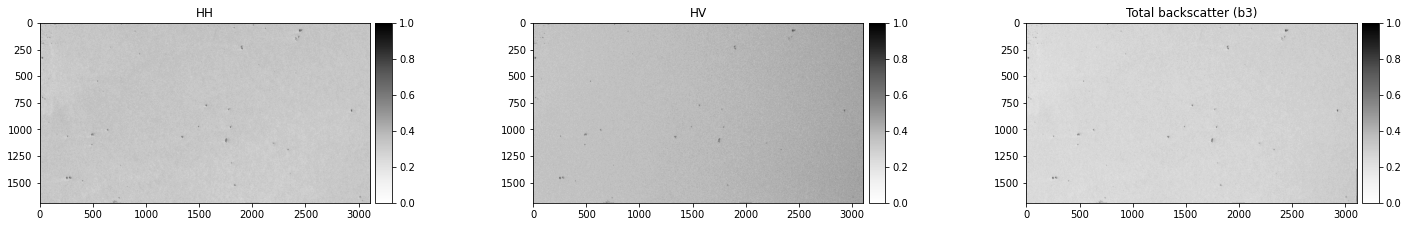

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,8))
hh_p = ax1.imshow(hh, cmap="Greys")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.08)
fig.colorbar(hh_p, ax=ax1, cax=cax)
ax1.set_title("HH")

hv_p = ax2.imshow(hv, cmap="Greys")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.08)
fig.colorbar(hv_p, ax=ax2, cax=cax)
ax2.set_title("HV")

b3_p = ax3.imshow(b3, cmap="Greys")
ax3.set_title("Total backscatter (b3)")
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.08)
fig.colorbar(b3_p, ax=ax1, cax=cax)

fig.subplots_adjust(wspace=0.4)

plt.show()

To reduce the speckle noise, apply our Lee filter and plot the output.

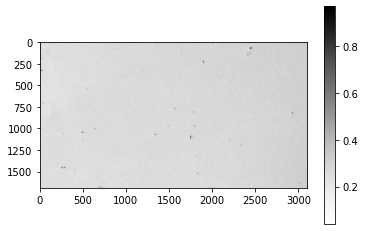

In [8]:
hh = lee_filter(hh, 20)
hv = lee_filter(hv, 20)
b3 = lee_filter(b3, 20)

plt.imshow(b3, cmap="Greys")
plt.colorbar()
plt.show()

Some bright objects are in the subset of the scene, most likely icebergs. To extract their position, I will calculate a threshold based on the median and the standard deviation fo the total backscatter. This is super simple but works quite well for this subset. I'm not sure how it will perform in other scenes (different inclination angles, rougher seas etc.), so we may think of something more advanced.

In [9]:
thresh = np.nanmedian(b3) + 5*np.std(b3)
print(thresh)

0.4397243373095989




All pixels above this threshold are considered to be bight and are likely ships or icebergs.

To extract the locations of the different objects and place a bounding box around them, I create an array with zeros (boring water) and ones (detected object).


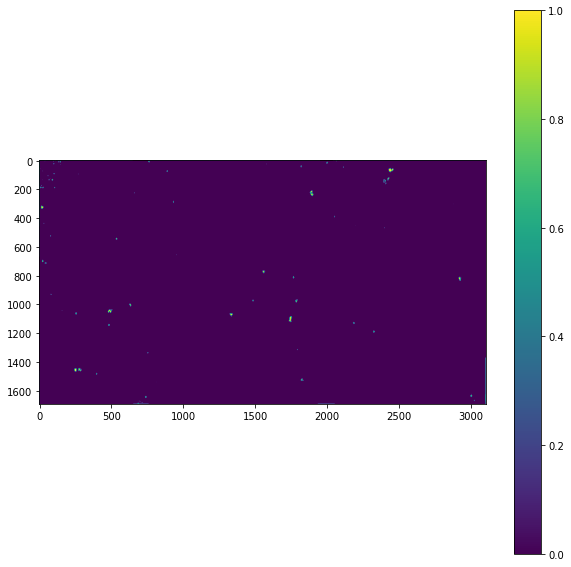

In [10]:
# Create array of zeros
roi = np.zeros(np.shape(b3))
# Mark all potential objects with ones
roi[b3>thresh] = 1

plt.figure(figsize=(10,10)) 
plt.imshow(roi)
plt.colorbar()
plt.show()



The bright objects visible in the total backscatter plot have been succesfully detected.

Several very small objects consisting of just one or two pixels were detected, because the total backscatter of these pixels were above our threshold. These pixels are very likely no real objects but image noise. To get rid of them, a unique value is assigned to each area of pixels with the same value. Then, all very small areas, which consist of less than 4 pixels, are removed from our list of potential objects. Finally, we can get the bounding boxes of the detected objects.


Number of potential objects before removing small ones: 129

Number of potential objects after removing small ones: 78



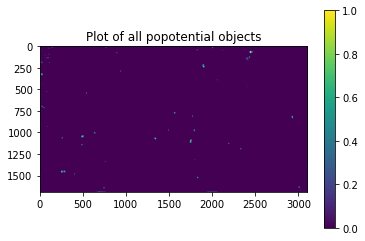


Number of potential objects after removing ones at the edges: 71



In [11]:
# Assign unique value for each region of same values
roi_labeled = measure.label(roi, connectivity=2)
print("Number of potential objects before removing small ones: " + str(np.max(roi_labeled)))

# Count occurences of unique values
unique, counts = np.unique(roi_labeled, return_counts=True)

# Get index of all regions consisting of less then 5 pixels 
# np where returns a tuple of an np.array, [0] at end gets only the np.array
idx = np.where(counts<5)[0]

# Assign 0 to all pixels in the roi-mask that are only small regions
for i in idx:
    roi[roi_labeled==i] = 0
    
# Assign unique value for each region of same values again, now without the small regions
roi_labeled = measure.label(roi, connectivity=2)
print("\nNumber of potential objects after removing small ones: " + str(np.max(roi_labeled)) + "\n")

plt.imshow(roi)
plt.colorbar()
plt.title("Plot of all popotential objects")
plt.show()

# Get bboxes of each region    
bboxes = [area.bbox for area in measure.regionprops(roi_labeled)]

# Remove all bboxes which are at the border of the image (likely not fully within the image)
bboxes = [bound for bound in bboxes if bound[0] > 0 and 
            bound[2]<np.shape(b3)[0] and
            bound[1]>0 and
            bound[3]<np.shape(b3)[1]]

print("\nNumber of potential objects after removing ones at the edges: " + str(len(bboxes)) + "\n")



Prepare python lists for our output.


In [12]:
geo_output = []

lat_max, lon_max = np.shape(lat)
lat_max = lat_max-1
lon_max = lon_max-1

geo_output.append([lat[0,0], lon[0,0], "upper left corner", np.nan])
geo_output.append([lat[0,lon_max], lon[0,lon_max], "upper right corner", np.nan])
geo_output.append([lat[lat_max,lon_max], lon[lat_max,lon_max], "lower right corner", np.nan])
geo_output.append([lat[lat_max,0], lon[lat_max,0], "lower right corner", np.nan])



Prepare a plot that shows our objects with a different coloured bounding box, depending on the object type. Then, iterate through all the obects, create a 75x75 subset with each object in the center. This subset is then fed into our model and the result is stored in the python lists.


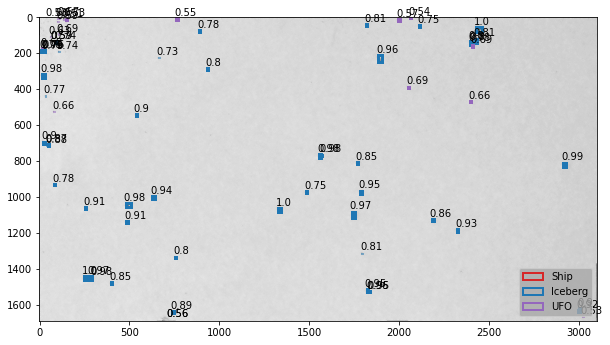

In [13]:
# Linewidth for Plot
lw = 3

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(b3, cmap="Greys")


for bbox in bboxes:
    # Calculate the extend of bbox
    height = bbox[2]-bbox[0]
    width = bbox[3]-bbox[1]
    # coordinates of upper left pexel of bbox (can be used for plotting)
    ul = [bbox[1], bbox[0]]
    
    # Calculate center of bbox
    c_x = (bbox[0]+bbox[2])/2
    c_y = (bbox[1]+bbox[3])/2
    roi_center = [c_x, c_y]

    # Define extend of 75*75 subset with center of bbox in the middle
    # a = sub_roi
    x1 = round(roi_center[0])-38
    x2 = round(roi_center[0])+37
    y1 = round(roi_center[1])-38
    y2 = round(roi_center[1])+37
    
    # If parts of the subset would be out of bounds of original image, place the subplot at the border of the image
    if x1 < 0:
        x1 = 0
        x2 = 75
    if y1 < 0:
        y1 = 0
        y2 = 75
    
    if x2 > np.shape(b3)[0]:
        x1 = np.shape(b3)[0]-76
        x2 = np.shape(b3)[0]-1
        
    if y2 > np.shape(b3)[1]:
        y1 = np.shape(b3)[1]-76
        y2 = np.shape(b3)[1]-1        
    

    sub_hh = hh[x1:x2, y1:y2]
    sub_hv = hv[x1:x2, y1:y2]
    sub_b3 = b3[x1:x2, y1:y2]
    

    sub_img = np.dstack((sub_hh, sub_hv, sub_b3))
    #print(np.shape(sub_img))
    sub_img = np.expand_dims(sub_img, axis=0)
    #print(np.shape(sub_img))

    # get local incident angle at the center of the bbox
    loc_inc = inc_angle[int(roi_center[0]), int(roi_center[1])]
    loc_inc = (loc_inc - 25)/(45-25)

    # feed sub_img into the model to predict
    output = model.predict([sub_img, np.array([loc_inc])], batch_size=1)
    
    #print(output)
    
    if output < 0.3:
        # Ship!
        #ships.append(bbox)
        geo_output.append([lat[int(roi_center[0]), int(roi_center[1])],
                             lon[int(roi_center[0]), int(roi_center[1])],
                             "ship", output[0][0]])
        box = mpatches.Rectangle((ul[0], ul[1]), width, height, 
                                 edgecolor='tab:red', linewidth=lw, fill=None)
    elif output > 0.7:
        # Iceberg!
        #icebergs.append(bbox)
        geo_output.append([lat[int(roi_center[0]), int(roi_center[1])],
                             lon[int(roi_center[0]), int(roi_center[1])],
                             "iceberg", output[0][0]])
        box = mpatches.Rectangle((ul[0], ul[1]), width, height, 
                                 edgecolor='tab:blue', linewidth=lw, fill=None)
    else:
        # Unknown floating object
        geo_output.append([lat[int(roi_center[0]), int(roi_center[1])],
                             lon[int(roi_center[0]), int(roi_center[1])],
                             "UFO", output[0][0]])
        box = mpatches.Rectangle((ul[0], ul[1]), width, height, 
                                 edgecolor='tab:purple', linewidth=lw, fill=None)
    
    ax.add_patch(box)
    ax.text(ul[0]-10, ul[1]-15, str(round(output[0][0],2)))



# Add legend to plot
l1 = mpatches.Patch(edgecolor='tab:red', facecolor='None', lw=2, label='Ship')
l2 = mpatches.Patch(edgecolor='tab:blue', facecolor='None', lw=2, label='Iceberg')
l3 = mpatches.Patch(edgecolor='tab:purple', facecolor='None', lw=2, label='UFO')
legend = ax.legend(handles=[l1, l2, l3], loc='lower right')

legend.legendPatch.set_facecolor('darkgrey')

plt.show()

Red boxes: Ships
Blue boxes: Icebergs
Purple boxes: object not identified

In [14]:
geo_output = pd.DataFrame(geo_output,columns=['lat', 'lon', 'object', 'probability'])
geo_output.to_csv("/content/drive/MyDrive/Iceberg_Ship_Classification/geo_output_" + file[:-11] +  ".csv", sep="\t", index=False)
geo_output.tail()

,lat,lon,object,probability
70,69.104958,-54.071983,iceberg,0.919408
71,69.069016,-53.513096,iceberg,0.893531
72,69.102531,-54.078781,UFO,0.534984
73,69.065117,-53.508209,UFO,0.561078
74,69.065094,-53.509243,UFO,0.562280
